<center>
<h1>CSCI3151 - Foundations of Machine Learning - Fall 2024</h1>
<h2>Assignment 5</h2>
</center>


**Due on: 17th November at 23:59 ADT**

- **Grade Period**: There is a 5-hour grace period after the deadline to allow for last minute technical issues.
- **Late Submissions:** You can submit the assignment up to 2 days late with a 20% penalty applied to your grade.
- **AI tools:** The policy on using AI tools is as discussed in class, and as described on Brightspace.
- **Working in Groups:** You may do this assignment alone or in groups of 2 or 3. If working in groups, only one person must submit it, and the assignment must clearly indicate the names and B-numbers and names of all group members.

[Assignment Submission Instructions as given on BrightSpace](https://dal.brightspace.com/d2l/le/content/342520/viewContent/4477501/View)

# Preamble

In this assignment, you’ll delve into learning the parameters of multiple Gaussian distributions to best fit a given dataset using the powerful **Expectation-Maximization (EM) algorithm**.

The EM algorithm is an iterative method that enables us to estimate the parameters for a mixture of Gaussians. The process begins by initializing random parameters for $k$-Gaussians, represented as $\mathcal{N}(\mu, \Sigma)$, where $\mu$ denotes the mean and $\Sigma$ the covariance matrix. Then, we alternate between two primary steps:

1. **Expectation Step (E-Step):** Given the current estimates of $\mu$ and $\Sigma$, calculate the "responsibility" or weight each Gaussian has for each data point. This responsibility quantifies the probability that each Gaussian generated each point.

2. **Maximization Step (M-Step):** Adjust the parameters $\mu$ (mean) and $\Sigma$ (covariance matrix) for each Gaussian based on the weighted contributions from the points for which it is most responsible.

By iterating these two steps, the EM algorithm gradually converges, refining each Gaussian to better represent clusters within the dataset.

# 1. Create A Dataset


As usual, we want to first create a synthetic dataset that we can fit. Use the `np.random.normal` function to create a function that allows you to sample from a dataset that consists of two Gaussians. Here's some starter code:

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Patch
import matplotlib.cm as cm


In [ ]:
# GRADED FUNCTION
def create_dataset(num_samples, mu1, sigma1, mu2, sigma2, pi1):
    """Creates a dataset from two Gaussian distributions.
    Args:
        num_samples: The total number of samples to generate
        mu1: Mean of the first Gaussian.
        sigma1: Standard deviation of the first Gaussian.
        mu2: Mean of the second Gaussian.
        sigma2: Standard deviation of the second Gaussian.
        pi1: Probability of sampling from the first Gaussian.
    Returns:
        A NumPy array containing the combined samples.
    """

    # Probability of sampling from the second Gaussian
    pi2 = 1 - pi1

    # Generate the samples from each Gaussian
    # YOUR CODE HERE
    samples1 = np.random.normal(mu1,sigma1,int(num_samples * pi1))
    samples2 = np.random.normal(mu2,sigma2,int(num_samples * pi2))


    # Then combine the samples into a single dataset and then shuffle it
    # (you can use np.random.shuffle and np.concatenate for this)
    dataset = np.concatenate((samples1, samples2))
    np.random.shuffle(dataset)

    return dataset

In block below we've provided you some helper functions for plotting. You can unhide the block and look at the code for details.

In [ ]:
# @title
# These are just some functions we created to help you visualize your data

def plot_data(dataset):
    plt.hist(dataset, bins=50, density=False, alpha=0.6, color='b')
    plt.title('Dataset Histogram')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()


def plot_dataset_with_gaussians(dataset, mu1, sigma1, mu2, sigma2):
    """Plots the dataset and overlays the two Gaussian distributions.
    Args:
    dataset: The dataset to plot.
    mu1: Mean of the first Gaussian.
    sigma1: Standard deviation of the first Gaussian.
    mu2: Mean of the second Gaussian.
    sigma2: Standard deviation of the second Gaussian.
    """

    plt.hist(dataset, bins=50, density=True, alpha=0.6, color='b', label='Dataset')
    x = np.linspace(min(dataset), max(dataset), 1000)
    plt.plot(x, norm.pdf(x, mu1, sigma1), color='r', label='Gaussian 1')
    plt.plot(x, norm.pdf(x, mu2, sigma2), color='g', label='Gaussian 2')

    plt.title('Dataset with Gaussian Distributions')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

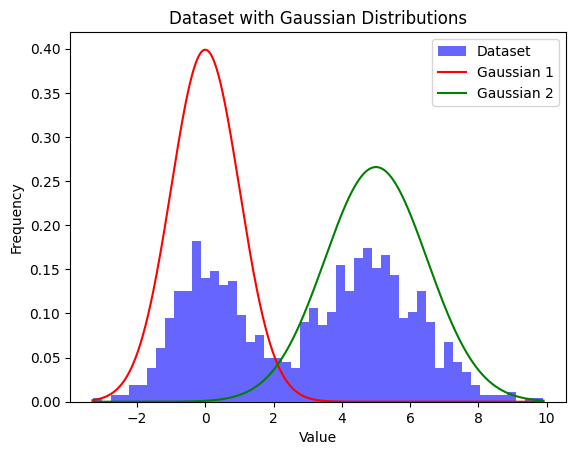

In [ ]:
mu1, sigma1 = 0, 1
mu2, sigma2 = 5., 1.5,
pi1 = 0.4
num_samples = 1000

# Example usage:
dataset = create_dataset(num_samples, mu1, sigma1, mu2, sigma2, pi1)
plot_dataset_with_gaussians(dataset, mu1, sigma1, mu2, sigma2)

# 2. Fitting Two 1-Dimensional Gaussians

Let's pretend we didn't know where this dataset came from. Let's hypothesize the it was the result of two Gaussians but we don't know the parameters of these Gaussians. We're going to use the EM-algorithm to find these parameters.

## 2.1 Compute Guassian Parameters

First write a function `computeParams` to compute the mean and standard deviation of a given dataset.

In [ ]:
# GRADED FUNCTION
def computeParams(dataset):
    '''
    Given a set of points {x1, x2, ..., xn} as dataset,
    compute the mean mu and standard deviation sigma of the dataset.
    '''
    mu = np.mean(dataset)
    sigma = np.std(dataset)
    # Keep in mind that while you can use np functions to compute these,
    # you need to exactly how to do this by hand if required to do so.

    return mu, sigma

## 2.2 Computing Probability Densities

Now write a function `computePDF` that calculates the probability density of a point $x$ under a given Gaussian with mean $\mu$ and standard deviation $\sigma$: $\mathcal{N}(x; \mu, \sigma)$. To help you out a little, here is the formula for this:

$$
\mathcal{N}(x; \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2 \sigma^2}\right)
$$

In [ ]:
# GRADED FUNCTION
def computePDF(x, mu, sigma):
    """
    Computes the probability density of a point x under a Gaussian distribution
    g(x, mu, sigma).

    Args:
        x: The point at which to evaluate the probability density.
        mu: The mean of the Gaussian distribution.
        sigma: The standard deviation of the Gaussian distribution.

    Returns:
        The probability density of x under the Gaussian distribution.
    """
    from numpy import pi
    # YOUR CODE HERE
    coefficient = 1 / (np.sqrt(2 * pi * sigma ** 2))
    exponent = -((x - mu) ** 2 / (2 * sigma ** 2))

    return coefficient * np.exp(exponent)

## 2.3 Computing Reponsibilities

Given a point $x$, and given the two Gaussians, use Bayes' rule to determine the probability that $x$ came from $g_1$ ($p(g_1 | x)$) probability that $x$ came from $g_2$ ($p(g_2 | x)$). First write down the math for it and then complete the function.

> Hint: just use Bayes' rule for each case.

We're going to say that the probaiblity that $x$ came from $g_1$ is how much $g_1$ is "responsible" for $x$.

### 2.3.1 Math Equations

Write the math equations relevant to the calculation to the responsibilities.

$$
p(g_1 | x) = p (x | g1) p(g1) / p(x)
$$
$$
p(g_2 | x) = p (x | g2) p(g2) / p(x)
$$
$$
p(x) = p (x | g1) p(g1) + p (x | g2) p(g2)
$$

### 2.3.2 Responsiblities Function

Write the corresponding function in Python using Numpy.

In [ ]:
# GRADED FUNCTION
def computeResponsibilities(x, mu1, mu2, sigma1, sigma2, pi1, pi2):
    '''
    Compute the responsibility of each Gaussian for the point x, including mixture weights.

    Args:
        x: The point at which to compute responsibilities.
        mu1, sigma1: Mean and standard deviation of Gaussian 1.
        mu2, sigma2: Mean and standard deviation of Gaussian 2.
        pi1, pi2: Mixture weights for Gaussian 1 and Gaussian 2.

    Returns:
        r1: The responsibility of Gaussian 1 for the point x.
        r2: The responsibility of Gaussian 2 for the point x.
    '''
    # YOUR CODE HERE

    # r1 = p(g1|x) = p(x|g1) * p (g1) / p (x)
    # r2 = p(g2|x) = p(x|g2) * p (g2) / p (x)

    px_g1 = computePDF(x, mu1, sigma1)
    px_g2 = computePDF(x, mu2, sigma2)

    p_g1 = pi1
    p_g2 = pi2

    p_x = p_g1 * px_g1 + p_g2 * px_g2

    r1 =  (px_g1 * p_g1) / p_x
    r2 =  (px_g2 * p_g2) / p_x

    return r1, r2


## 2.4 Weighted Mean and Standard Deviation

In step 1, we wrote a function to `computeParams` that calculates an unweighted mean and standard deviation of the dataset. Update that function to take a set of weights can calculated a weighted mean and standard deviation.

$$
\mu = \frac{\sum_{i=1}^{n} w_i x_i}{\sum_{i=1}^{n} w_i} \\
\sigma = \sqrt{\frac{\sum_{i=1}^{n} w_i (x_i - \mu)^2}{\sum_{i=1}^{n} w_i}}
$$

In [ ]:
# GRADED FUNCTION
def computeWeightedParams(dataset, weights):
    '''
    Given a set of points {x1, x2, ..., xn} as dataset,
    compute the weighted mean mu and standard deviation sigma of the dataset.
    '''
    mu = np.sum (weights * dataset) / np.sum (weights)
    sigma = np.sqrt (np.sum (weights * ((dataset - mu) ** 2)) / np.sum (weights))

    return mu, sigma

## 2.5 Combining Everything to get the EM algorithm

1. Assume you're given a datset.
2. First, randomly initialize two Gaussians.
3. For each point $x^{(i)}$ in the dataset:
    - compute $p(g_1 | x^{(i)})$ and $p(g_2 | x^{(i)})$
    - let $w^{(i)}_1 = p(g_1 | x^{(i)})$ and $w^{(i)}_2 = p(g_2 | x^{(i)})$
4. Now use the newly computed $w$'s as weights to recompute the means and variances of the two gaussians: $\mu_1, \mu_2, \sigma_1, \sigma_2$.
5. Repeat 3 and 4 until $\mu_1, \mu_2$ don't change (up to some threshold $\delta$).

In [ ]:
# GRADED CLASS
class EM:
    def __init__(self):
        '''
        Initialize the EM algorithm with default tolerance and iteration settings.

        Parameters:
        - tol (float): Convergence tolerance.
        - max_iter (int): Maximum number of iterations.
        '''
        self.tol = None
        self.max_iter = None
        self.mu1 = None
        self.sigma1 = None
        self.mu2 = None
        self.sigma2 = None
        self.w = None
        self.pi1 = None
        self.pi2 = None

    def initialize_params(self, dataset):
        '''Initialize parameters based on the range of the dataset.'''
        min_val, max_val = np.min(dataset), np.max(dataset)

        self.mu1, self.mu2 = np.random.uniform(min_val, max_val, 2)

        data_range = max_val - min_val
        self.sigma1 = data_range / 4
        self.sigma2 = data_range / 4

        self.pi1 = 0.5
        self.pi2 = 0.5

        self.w = np.ones((len(dataset),2)) / 2

    def e_step(self, dataset):
        '''Perform the E-step: compute responsibilities for each data point.'''
        # YOUR CODE HERE

        responsibilities = np.zeros((len(dataset), 2))

        for i, x in enumerate(dataset):
            r1, r2 = computeResponsibilities(x, self.mu1, self.mu2, self.sigma1, self.sigma2, self.pi1, self.pi2)
            responsibilities[i, 0] = r1
            responsibilities[i, 1] = r2

        self.pi1 = np.mean(responsibilities[:,0])  # computing the pi's could also be moved to the m_step
        self.pi2 = np.mean(responsibilities[:,1])

        return responsibilities

    def m_step(self, dataset, responsibilities):
        '''Perform the M-step: update the parameters based on the responsibilities.'''
        # YOUR CODE HERE
        weights1 = responsibilities[:,0]
        self.mu1, self.sigma1 = computeWeightedParams(dataset, weights1)[:2]

        weights2 = responsibilities[:,1]
        self.mu2, self.sigma2 = computeWeightedParams(dataset, weights2)[:2]

    def fit(self, dataset, tol=1e-4, max_iter=1000):
        '''Initialize parameters based on dataset and run the EM algorithm.'''
        self.initialize_params(dataset)

        for iteration in range(max_iter):
            # YOUR CODE HERE
            responsibilities = self.e_step(dataset)
            self.m_step(dataset, responsibilities)
            old_mu1, old_mu2 = self.mu1, self.mu2


            # Check for convergence
            if abs(self.mu1 - old_mu1) < tol and abs(self.mu2 - old_mu2) < tol:
                print(f'Converged after {iteration + 1} iterations.')
                break
        else:
            print(f'Did not converge within {max_iter} iterations.')

    def get_parameters(self):
        '''Return the parameters of the Gaussian distributions.'''
        return {
            'mu1': np.round(self.mu1,2),
            'sigma1': np.round(self.sigma1,2),
            'pi1': np.round(self.pi1,2),
            'mu2': np.round(self.mu2,2),
            'sigma2': np.round(self.sigma2,2),
            'pi2': np.round(self.pi2,2),
        }


In the next block is a helper function we have provided for printing out the parameter values. Please feel free to look at it if you wish.

In [ ]:
# @title
def print_parameters(original, learned):
    print("\nComparison of Original and Learned Parameters (Grouped by Closest Match):\n")

    # Extract and organize the original and learned components
    original_components = [
        {'mu': original['mu1'], 'sigma': original['sigma1'], 'pi': original['pi1']},
        {'mu': original['mu2'], 'sigma': original['sigma2'], 'pi': original['pi2']}
    ]
    learned_components = [
        {'mu': learned['mu1'], 'sigma': learned['sigma1'], 'pi': learned['pi1']},
        {'mu': learned['mu2'], 'sigma': learned['sigma2'], 'pi': learned['pi2']}
    ]

    # Sort learned components to pair them with the closest original component based on mean (mu)
    if abs(original_components[0]['mu'] - learned_components[1]['mu']) < abs(original_components[0]['mu'] - learned_components[0]['mu']):
        # Swap to align close components
        learned_components[0], learned_components[1] = learned_components[1], learned_components[0]

    # Print the parameters in a structured format
    print(f"{'Parameter':<12} {'Original':<25} {'Learned':<25}")
    print("-" * 55)
    for i in range(2):
        print(f"{'mu':<12} {original_components[i]['mu']:<25} {learned_components[i]['mu']:<25}")
        print(f"{'sigma':<12} {original_components[i]['sigma']:<25} {learned_components[i]['sigma']:<25}")
        print(f"{'pi':<12} {original_components[i]['pi']:<25} {learned_components[i]['pi']:<25}")
        print("-" * 55)


In [ ]:
# TRY OUT DIFFERENT VALUES HERE TO TEST YOUR IMPLEMENTATION
mu1, sigma1 = 0, 1
mu2, sigma2 = 5, 1.5,
pi1 = 0.4
num_samples = 10000

original_parameters = {
    'mu1': mu1, 'sigma1': sigma1, 'pi1': pi1,
    'mu2': mu2, 'sigma2': sigma2, 'pi2': 1 - pi1
}

dataset = create_dataset(num_samples, mu1, sigma1, mu2, sigma2, pi1)

# Initialize the EM model
model = EM()

# Fit the model on the dataset
model.fit(dataset)

# Retrieve and print the final parameters
learned_parameters = model.get_parameters()

# Print out both sets of parameters for easy comparison
print_parameters(original_parameters, learned_parameters)

Converged after 1 iterations.

Comparison of Original and Learned Parameters (Grouped by Closest Match):

Parameter    Original                  Learned                  
-------------------------------------------------------
mu           0                         2.67                     
sigma        1                         2.77                     
pi           0.4                       0.63                     
-------------------------------------------------------
mu           5                         3.55                     
sigma        1.5                       2.72                     
pi           0.6                       0.37                     
-------------------------------------------------------


## 3. Extending EM to 2 dimensions.

Here you will extend the EM algorithm to 2D. It will be very similar to what you did above. We've copied (and slightly modified as needed) the code from above down to here. You'll need to fill most of the same things in again, but a few lines will be a little bit different in order to account for the change to 2D. The main changes are the following:

* We've provided a function to create 2D datasets below.
* You will need to make sure the means are 2D, and instead of variances, you need to use a covariance matrix.
* You also need to use the multivariate gaussian function to compute the probability, i.e. $p(x | \mu , \Sigma)$.

We've also provided a "<i>tentative</i>" function that can plot the data in 2D along with ellipses corresponding to your current model's gaussians. So for example, if your model has learned the "correct" gaussian, then the ellipses should visibly look like they fit the data. Also, if you use a mixture of 2 or 3 gaussians, then you can plot it in 'show responsibility' mode, so that the points are coloured according to which gaussian is responsible for them. These plots will be shown in class. This can be helpful both for debugging and also simply for understanding what is happening. (You're welcome to change the plotting functionality as you wish to make them more convenient for yourself). Note that we have not tested this plotting function thoroughly; it is meant to be a helpful tool, but it is also possible that it can break in certain cases.


In [ ]:
# @title

######## Plotting helper functions

# Function to calculate responsibilities for each point
def calculate_rvals(data, means, covariances, proportions):
    n_points = data.shape[0]
    n_gaussians = len(means)
    rvals = np.zeros((n_points, n_gaussians))

    for i in range(n_gaussians):
        diff = data - means[i]
        cov_inv = np.linalg.inv(covariances[i])
        exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
        normalization = 1 / (2 * np.pi * np.sqrt(np.linalg.det(covariances[i])))
        rvals[:, i] = proportions[i] * normalization * np.exp(exponent)

    rvals /= np.sum(rvals, axis=1, keepdims=True)
    return rvals

# Function to mix colors based on responsibilities
def mix_colors(rvals, colors):
    mixed_colors = np.dot(rvals, colors)
    return mixed_colors

# Function to plot dataset and Gaussian ellipses with specified color options
def plot_dataset_and_gaussians(data, means=None, covariances=None, proportions=None,
                               color_mode='uniform', plot_data=True, plot_gaussians=True):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('black')  # Set background to black

    # Define colors for each Gaussian
    colors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # Red, Green, Blue
    if len(means) > 3 :
      color_mode = 'uniform'
    if len(means) == 2:
      colors = np.array([[1,0,0], [0,0,1]])
    if len(means) == 1:
      color_mode = 'uniform'


    if plot_data:
        if color_mode == 'uniform':
            ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.6, color='cyan', label='Data Points')
        elif color_mode == 'responsibilities' and means is not None and covariances is not None and proportions is not None:
            rvals = calculate_rvals(data, means, covariances, proportions)
            mixed_colors = mix_colors(rvals, colors)
            ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.6, c=mixed_colors, label='Data Points')

    if plot_gaussians and means is not None and covariances is not None:
        for mean, cov in zip(means, covariances):
            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
            width, height = 2 * np.sqrt(eigenvalues)
            ellipse = Ellipse(
                xy=mean, width=width, height=height, angle=angle,
                edgecolor='lime', facecolor='none', lw=2
            )
            ax.add_patch(ellipse)

    # Add legend for the Gaussian responsibility colors
    if color_mode == 'responsibilities' and means is not None and covariances is not None and proportions is not None:
      if len(means) == 3:
        legend_elements = [
            Patch(facecolor='red', edgecolor='white', label='Gaussian 1'),
            Patch(facecolor='green', edgecolor='white', label='Gaussian 2'),
            Patch(facecolor='blue', edgecolor='white', label='Gaussian 3')
        ]
        ax.legend(handles=legend_elements, facecolor='white', edgecolor='yellow', fontsize=10)

      if len(means) == 2:
        legend_elements = [
            Patch(facecolor='red', edgecolor='white', label='Gaussian 1'),
            Patch(facecolor='blue', edgecolor='white', label='Gaussian 2')
        ]
        ax.legend(handles=legend_elements, facecolor='white', edgecolor='yellow', fontsize=10)


    ax.set_xlabel("X-axis", fontsize=12, color='black')
    ax.set_ylabel("Y-axis", fontsize=12, color='black')
    ax.set_title("2D Gaussian Mixture and Data Points", fontsize=14, fontweight='normal', color='black')
    plt.grid(True, linestyle='--', alpha=0.3, color='white')
    plt.tight_layout()
    plt.show()


In [ ]:
# @title

def create_dataset2D(num_samples, mu1, sigma1, mu2, sigma2, pi1):
    '''Generate a synthetic 2D dataset based on the given parameters.'''
    num_samples_1 = int(num_samples * pi1)
    num_samples_2 = num_samples - num_samples_1

    # Generate samples for each Gaussian component
    samples1 = np.random.multivariate_normal(mu1, sigma1, num_samples_1)
    samples2 = np.random.multivariate_normal(mu2, sigma2, num_samples_2)

    return np.vstack((samples1, samples2))



In [ ]:
# GRADED CLASS
import numpy as np

class EM2D:
    def __init__(self):
        '''
        Initialize the EM algorithm for 2D data with default tolerance and iteration settings.

        Parameters:
        - tol (float): Convergence tolerance.
        - max_iter (int): Maximum number of iterations.
        '''
        self.tol = None
        self.max_iter = None
        self.mu1 = None
        self.sigma1 = None
        self.mu2 = None
        self.sigma2 = None
        self.w = None
        self.pi1 = None
        self.pi2 = None

    def initialize_params(self, dataset):
        '''Initialize parameters based on the range of the 2D dataset.'''
        n, d = dataset.shape
        # We've adjusted this function for 2D data
        min_vals, max_vals = np.min(dataset, axis=0), np.max(dataset, axis=0)

        self.mu1 = np.random.uniform(min_vals, max_vals)
        self.mu2 = np.random.uniform(min_vals, max_vals)

        data_range = max_vals - min_vals
        self.sigma1 = np.eye(d) * (np.mean(data_range) / 4)
        self.sigma2 = np.eye(d) * (np.mean(data_range) / 4)

        self.pi1 = 0.5
        self.pi2 = 0.5

        self.w = np.ones((n, 2)) / 2

    def gaussian_pdf(self, x, mean, cov):
        '''Calculate the Gaussian probability density function in 2D.'''

        cov_inv = np.linalg.inv(cov) # use numpy to compute the inverse

        # YOUR CODE HERE TO COMPLETE THE COMPUTATION OF THE GAUSSIAN
        d = len(mean)  # Dimensionality
        diff = x - mean  # Difference between point and mean
        exponent = -0.5 * diff.T @ cov_inv @ diff  # Quadratic form

        return np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))

    def e_step(self, dataset):
        '''Perform the E-step: compute responsibilities for each data point.'''
        n = len(dataset)
        responsibilities = np.zeros((n, 2))

        # YOUR CODE GOES HERE
        for i, x in enumerate(dataset):
          p1 = self.pi1 * self.gaussian_pdf(x, self.mu1, self.sigma1)
          p2 = self.pi2 * self.gaussian_pdf(x, self.mu2, self.sigma2)
          total = p1 + p2
          responsibilities[i, 0] = p1 / total  # Responsibility for Gaussian 1
          responsibilities[i, 1] = p2 / total  # Responsibility for Gaussian 2

        return responsibilities

    def m_step(self, dataset, responsibilities):
        '''Perform the M-step: update the parameters based on the responsibilities.'''
        n, d = dataset.shape

        # YOUR CODE GOES HERE
        r1 = responsibilities[:, 0]
        r2 = responsibilities[:, 1]
        total_r1 = np.sum(r1)
        total_r2 = np.sum(r2)

        # Update means
        self.mu1 = np.sum(r1[:, None] * dataset, axis=0) / total_r1
        self.mu2 = np.sum(r2[:, None] * dataset, axis=0) / total_r2

        # Update covariances
        self.sigma1 = (dataset - self.mu1).T @ np.diag(r1) @ (dataset - self.mu1) / total_r1
        self.sigma2 = (dataset - self.mu2).T @ np.diag(r2) @ (dataset - self.mu2) / total_r2

        # Update weights
        self.pi1 = total_r1 / n
        self.pi2 = total_r2 / n

    def fit(self, dataset, tol=1e-4, max_iter=1000,plot_data=False):
        '''Initialize parameters based on the dataset and run the EM algorithm for 2D data.'''
        self.initialize_params(dataset)

        for iteration in range(max_iter):
            if (plot_data == True):
                # plot the data in current state with current params
                plot_dataset_and_gaussians(dataset, means=[self.mu1, self.mu2], covariances=[self.sigma1, self.sigma2], proportions=[self.pi1, self.pi2], color_mode='responsibilities')

            # YOUR CODE HERE
            # Perform E-step
            responsibilities = self.e_step(dataset)

            # Store old means for convergence check
            old_mu1, old_mu2 = np.copy(self.mu1), np.copy(self.mu2)

            # Perform M-step
            self.m_step(dataset, responsibilities)

            # Check for convergence
            if np.linalg.norm(self.mu1 - old_mu1) < tol and np.linalg.norm(self.mu2 - old_mu2) < tol:
                print(f'Converged after {iteration + 1} iterations.')
                break
        else:
            print(f'Did not converge within {max_iter} iterations.')

    def get_parameters(self):
        '''Return the parameters of the 2D Gaussian distributions.'''
        return {
            'mu1': np.round(self.mu1, 2),
            'sigma1': np.round(self.sigma1, 2),
            'pi1': np.round(self.pi1, 2),
            'mu2': np.round(self.mu2, 2),
            'sigma2': np.round(self.sigma2, 2),
            'pi2': np.round(self.pi2, 2),
        }



Below is a function we have provided for printing the parameters of your model. Feel free to look at the code if you wish.

In [ ]:
# @title
def print_parameters2D(original, learned):
  # We've adjusted this so that it works for 2D.
    print("\nComparison of Original and Learned Parameters (Grouped by Closest Match):\n")

    # Extract and organize the original and learned components
    original_components = [
        {'mu': original['mu1'], 'sigma': original['sigma1'], 'pi': original['pi1']},
        {'mu': original['mu2'], 'sigma': original['sigma2'], 'pi': original['pi2']}
    ]
    learned_components = [
        {'mu': learned['mu1'], 'sigma': learned['sigma1'], 'pi': learned['pi1']},
        {'mu': learned['mu2'], 'sigma': learned['sigma2'], 'pi': learned['pi2']}
    ]


    # Compute the Euclidean distance between original and learned means to find the closest match
    distance_1 = np.linalg.norm(original_components[0]['mu'] - learned_components[1]['mu'])
    distance_2 = np.linalg.norm(original_components[0]['mu'] - learned_components[0]['mu'])

    if distance_1 < distance_2:
        # Swap to align close components
        learned_components[0], learned_components[1] = learned_components[1], learned_components[0]

    # Print the parameters in a structured format
    print(f"{'Parameter':<12} {'Original':<40} {'Learned':<40}")
    print("-" * 80)
    for i in range(2):
        # Convert numpy arrays to strings for means
        mu_original_str = np.array2string(original_components[i]['mu'], precision=2)
        mu_learned_str = np.array2string(learned_components[i]['mu'], precision=2)

        # Print means
        print(f"{'mu':<12} {mu_original_str:<40} {mu_learned_str:<40}")

        # Print covariance matrices below the "sigma" label
        print(f"{'sigma':<12}")
        print(f"{'':<12}Original:\n\t{np.array2string(original_components[i]['sigma'], precision=2, separator=', ')}")
        print(f"{'':<12}Learned:\n\t{np.array2string(learned_components[i]['sigma'], precision=2, separator=', ')}")

        # Print mixing proportions
        print(f"{'pi':<12} {original_components[i]['pi']:<40} {learned_components[i]['pi']:<40}")
        print("-" * 80)

# Use the function
# print_parameters2D(original_parameters2D, learned_parameters)


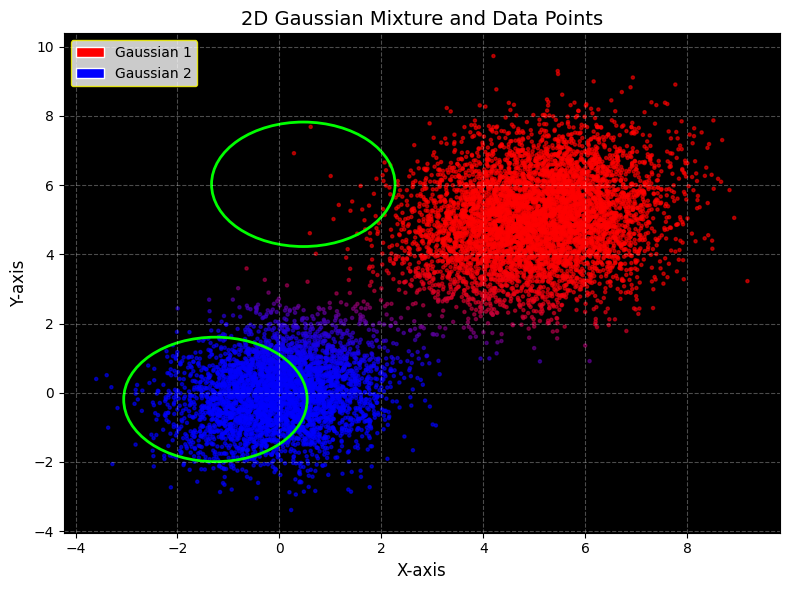

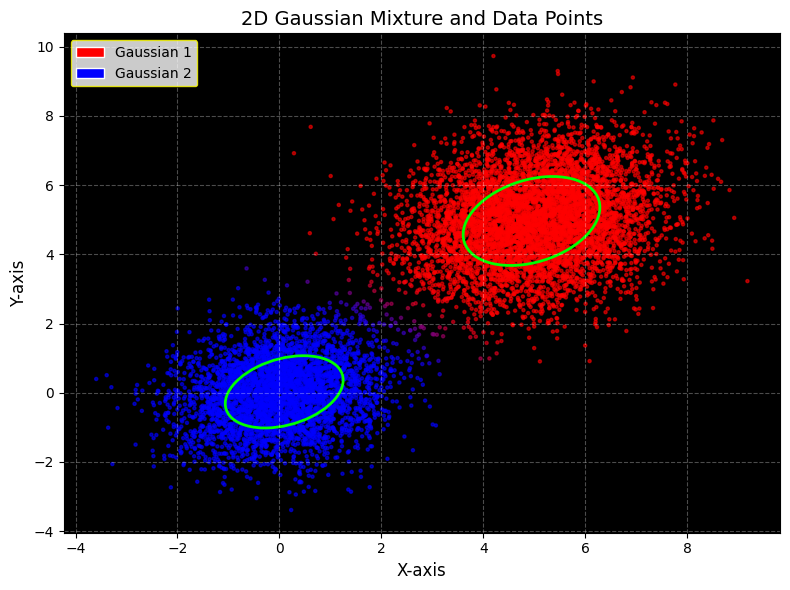

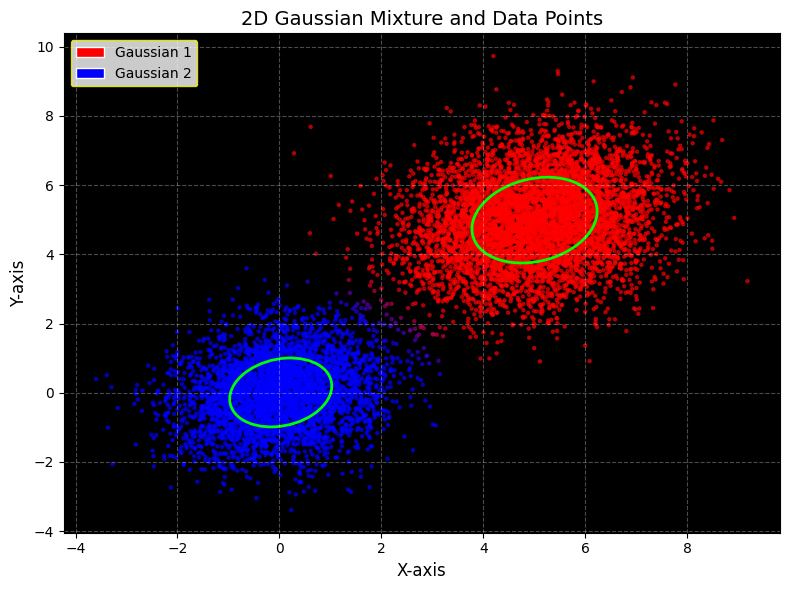

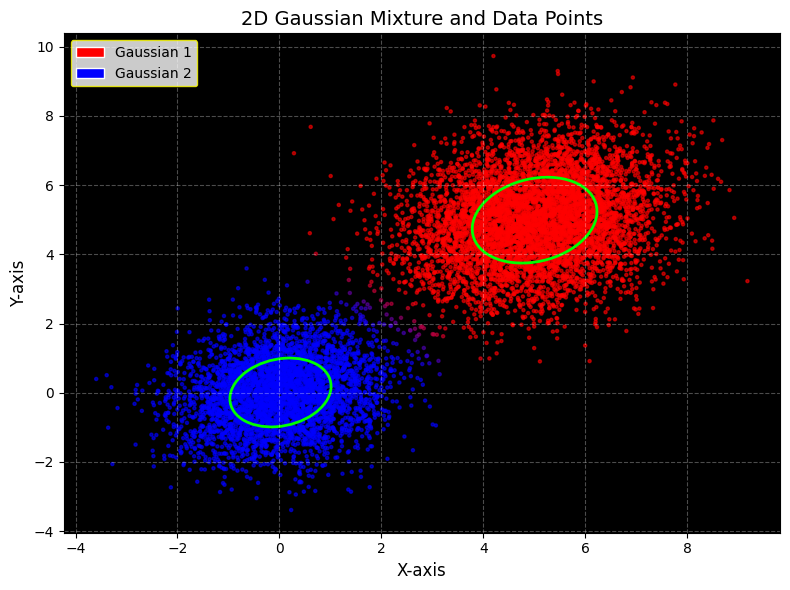

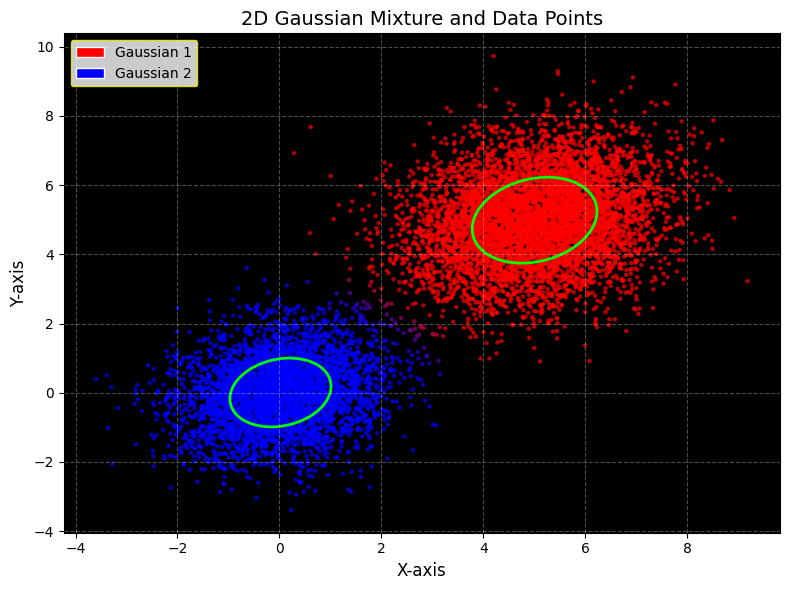

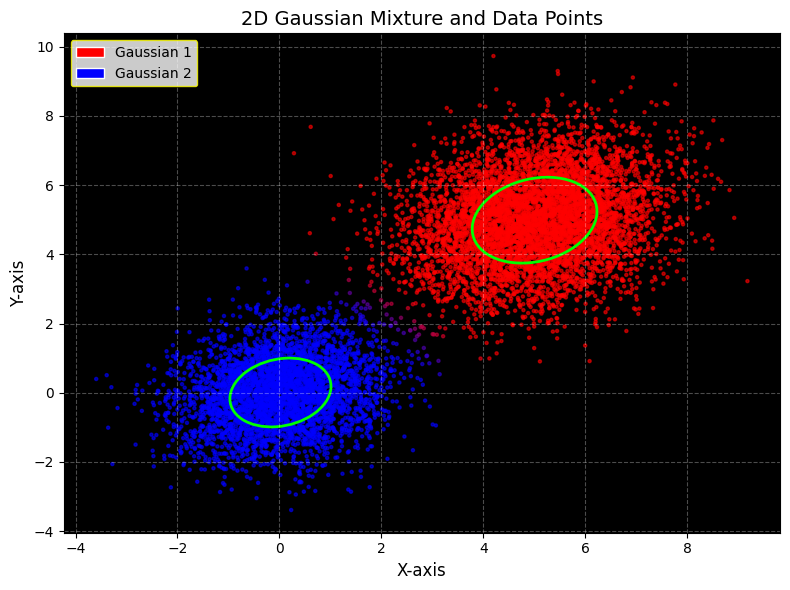

Converged after 6 iterations.

Comparison of Original and Learned Parameters (Grouped by Closest Match):

Parameter    Original                                 Learned                                 
--------------------------------------------------------------------------------
mu           [0 0]                                    [0.02 0.01]                             
sigma       
            Original:
	[[1. , 0.2],
 [0.2, 1. ]]
            Learned:
	[[0.98, 0.18],
 [0.18, 0.99]]
pi           0.4                                      0.4                                     
--------------------------------------------------------------------------------
mu           [5 5]                                    [5.   4.99]                             
sigma       
            Original:
	[[1.5, 0.3],
 [0.3, 1.5]]
            Learned:
	[[1.5 , 0.31],
 [0.31, 1.54]]
pi           0.6                                      0.6                                     
-----------------------------

In [ ]:
# TRY DIFFERENT VALUES HERE TO TEST YOUR IMPLEMENTATION

# Define the original parameters for the 2D Gaussian components
mu1 = np.array([0, 0])
sigma1 = np.array([[1, 0.2], [0.2, 1]])
mu2 = np.array([5, 5])
sigma2 = np.array([[1.5, 0.3], [0.3, 1.5]])
pi1 = 0.4
num_samples = 10000

original_parameters2D = {
    'mu1': mu1, 'sigma1': sigma1, 'pi1': pi1,
    'mu2': mu2, 'sigma2': sigma2, 'pi2': 1 - pi1
}

# Generate the synthetic 2D dataset
dataset = create_dataset2D(num_samples, mu1, sigma1, mu2, sigma2, pi1)

# Initialize the EM model for 2D
model = EM2D()

# Fit the model on the dataset
model.fit(dataset, plot_data=True)

# Retrieve and print the final parameters
learned_parameters2D = model.get_parameters()

# Print out both sets of parameters for easy comparison
print_parameters2D(original_parameters2D, learned_parameters2D)